# Task 5: Distributed Search - Programming Assignment

**Course:** Parallel Computing Systems - Winter Semester 2025/2026  
**Professor:** Prof. Dr.-Ing. Mladen Berekovic  
**Student:** Md Norul Gofran  
**Date:** November 3, 2025

---

## Problem Statement

Consider a string with length `n` of unique characters. To search for a character `c`, a sequential approach will require up to **O(n)** time in the worst case.


### Objectives:
1. Implement a **sequential** search algorithm as baseline
2. Implement the **best parallelized version** using CRCW-PRAM model
3. Benchmark and compare performance between sequential and parallel
4. Calculate speedup and efficiency
5. Visualize results with comprehensive plots and charts

## 1. Import Required Libraries

Import all necessary libraries for implementation, timing, and visualization.

In [27]:
import time
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Manager
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")

All libraries imported successfully


## 2. Generate Test Data

Create test strings of various lengths for comprehensive performance analysis.

In [28]:
def generate_test_string(n):
    chars = string.ascii_letters + string.digits + string.punctuation
    if n <= len(chars):
        return ''.join(random.sample(chars, n))
    else:
        base = list(chars)
        while len(base) < n:
            base.append(f"char_{len(base)}")
        return base[:n]

test_sizes = [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]
test_data = {}

print("Generating test data...")
for size in test_sizes:
    print(f"  Creating dataset n={size:,}...", end=' ')
    test_data[size] = generate_test_string(size)
    print("✓")
    
print(f"\n✓ Generated {len(test_sizes)} test datasets")
print("\nDataset samples:")
for size, data in list(test_data.items())[:3]:
    sample = data[:20] if isinstance(data, str) else ''.join(str(x) for x in data[:20])
    print(f"  n={size:8,}: {sample}...")

Generating test data...
  Creating dataset n=10,000... ✓
  Creating dataset n=50,000... ✓
  Creating dataset n=100,000... ✓
  Creating dataset n=500,000... ✓
  Creating dataset n=1,000,000... ✓
  Creating dataset n=5,000,000... ✓
  Creating dataset n=10,000,000... ✓

✓ Generated 7 test datasets

Dataset samples:
  n=  10,000: abcdefghijklmnopqrst...
  n=  50,000: abcdefghijklmnopqrst...
  n= 100,000: abcdefghijklmnopqrst...


## 3. Sequential Search Implementation (Baseline)

**Algorithm:** Linear Search  
**Time Complexity:** O(n)  
**Space Complexity:** O(1)  
**Description:** Traditional sequential search through the string, checking each character one by one.

In [34]:
def sequential_search(data, target):
    for i in range(len(data)):
        if data[i] == target:
            return i
    return -1

test_string = test_data[10000]
test_char = test_string[7500]

start_time = time.time()
result = sequential_search(test_string, test_char)
end_time = time.time()

print("Sequential Search Test:")
print(f"  String length: {len(test_string)}")
print(f"  Target character: '{test_char}'")
print(f"  Found at index: {result}")
print(f"  Time taken: {(end_time - start_time)*1000:.6f} ms")
print(f"  Time complexity: O(n)")

Sequential Search Test:
  String length: 10000
  Target character: 'char_7500'
  Found at index: 7500
  Time taken: 0.737906 ms
  Time complexity: O(n)


## 4. Parallel Search Implementation - CRCW-PRAM

**Model:** CRCW-PRAM (Concurrent Read Concurrent Write - Parallel Random Access Machine)  
**Time Complexity:** O(n/p) where p is the number of processors  
**Space Complexity:** O(p)


### Algorithm Description:
1. Divide the input string into `p` equal segments
2. Assign each segment to a processor
3. Each processor searches its segment concurrently
4. All processors can write results simultaneously
5. Apply conflict resolution to get the final answer

In [35]:
def crcw_search_worker(data, target, start_index, end_index, result_list, proc_id):
    for i in range(start_index, end_index):
        if data[i] == target:
            result_list[proc_id] = i
            return
    result_list[proc_id] = -1

def crcw_pram_search(data, target, num_processors):
    n = len(data)
    segment_size = n // num_processors
    
    manager = Manager()
    result_list = manager.list([-1] * num_processors)
    
    with ThreadPoolExecutor(max_workers=num_processors) as executor:
        futures = []
        for i in range(num_processors):
            start = i * segment_size
            end = start + segment_size if i < num_processors - 1 else n
            futures.append(
                executor.submit(crcw_search_worker, data, target, start, end, 
                              result_list, i)
            )
        
        for f in futures:
            f.result()
    
    valid_results = [r for r in result_list if r != -1]
    return min(valid_results) if valid_results else -1

num_procs = 8

start_time = time.time()
result_parallel = crcw_pram_search(test_string, test_char, num_procs)
end_time = time.time()

print("CRCW-PRAM Parallel Search Test:")
print(f"  String length: {len(test_string)}")
print(f"  Processors: {num_procs}")
print(f"  Target character: '{test_char}'")
print(f"  Found at index: {result_parallel}")
print(f"  Time taken: {(end_time - start_time)*1000:.6f} ms")
print(f"  Time complexity: O(n/p) = O({len(test_string)}/{num_procs})")

if result == result_parallel:
    print("\n✓ Parallel implementation produces correct result!")
else:
    print(f"\n⚠ Warning: Results differ (Sequential: {result}, Parallel: {result_parallel})")

CRCW-PRAM Parallel Search Test:
  String length: 10000
  Processors: 8
  Target character: 'char_7500'
  Found at index: 7500
  Time taken: 98.882198 ms
  Time complexity: O(n/p) = O(10000/8)

✓ Parallel implementation produces correct result!


## 5. Performance Benchmarking

Comprehensive benchmarking of sequential vs parallel implementations across different data sizes and processor counts.

In [36]:
def benchmark_algorithm(data, target, algorithm, num_processors=None, iterations=10):
    times = []
    for _ in range(iterations):
        start = time.time()
        if num_processors:
            algorithm(data, target, num_processors)
        else:
            algorithm(data, target)
        end = time.time()
        times.append((end - start) * 1000)
    
    return np.mean(times)

def benchmark_parallel_search(data, target, num_processors, executor, manager, iterations=10):
    times = []
    for _ in range(iterations):
        result_list = manager.list([-1] * num_processors)
        
        start = time.time()
        
        n = len(data)
        segment_size = n // num_processors
        futures = []
        for i in range(num_processors):
            seg_start = i * segment_size
            seg_end = seg_start + segment_size if i < num_processors - 1 else n
            futures.append(
                executor.submit(crcw_search_worker, data, target, seg_start, seg_end, 
                              result_list, i)
            )
        
        for f in futures:
            f.result()
        
        valid_results = [r for r in result_list if r != -1]
        _ = min(valid_results) if valid_results else -1
        
        end = time.time()
        
        times.append((end - start) * 1000)
    
    return np.mean(times)

processor_counts = [2, 4, 8, 16, 32]
benchmark_results = []

print("Running Comprehensive Benchmarks...")
print("This may take a few minutes...\n")

manager_global = Manager()
with ThreadPoolExecutor(max_workers=max(processor_counts)) as executor_global:

    for size in test_sizes:
        data = test_data[size]
        target = data[int(size * 0.75)]
        
        print(f"\nBenchmarking n = {size:6d}")
        print("-" * 80)
        
        seq_time = benchmark_algorithm(data, target, sequential_search)
        print(f"  Sequential:        {seq_time:10.4f} ms")
        
        benchmark_results.append({
            'size': size,
            'algorithm': 'Sequential',
            'processors': 1,
            'time_ms': seq_time,
            'speedup': 1.0,
            'efficiency': 1.0
        })
        
        for num_procs in processor_counts:
            parallel_time = benchmark_parallel_search(data, target, num_procs, 
                                                      executor_global, manager_global)
            speedup = seq_time / parallel_time
            efficiency = speedup / num_procs
            
            benchmark_results.append({
                'size': size,
                'algorithm': 'CRCW-PRAM',
                'processors': num_procs,
                'time_ms': parallel_time,
                'speedup': speedup,
                'efficiency': efficiency
            })
            
            print(f"  Parallel (p={num_procs:2d}):  {parallel_time:10.4f} ms | "
                  f"Speedup: {speedup:5.2f}x | Efficiency: {efficiency:5.2%}")

df_results = pd.DataFrame(benchmark_results)

print("\n" + "="*80)
print("✓ Benchmarking Complete!")
print(f"  Total configurations tested: {len(df_results)}")
print(f"  Data sizes: {len(test_sizes)}")
print(f"  Processor counts: {len(processor_counts)}")


Running Comprehensive Benchmarks...
This may take a few minutes...


Benchmarking n =  10000
--------------------------------------------------------------------------------
  Sequential:            0.1528 ms
  Parallel (p= 2):      0.3903 ms | Speedup:  0.39x | Efficiency: 19.57%
  Parallel (p= 4):      0.5434 ms | Speedup:  0.28x | Efficiency: 7.03%
  Parallel (p= 8):      1.4090 ms | Speedup:  0.11x | Efficiency: 1.36%
  Parallel (p=16):     15.1623 ms | Speedup:  0.01x | Efficiency: 0.06%
  Parallel (p=32):      2.3387 ms | Speedup:  0.07x | Efficiency: 0.20%

Benchmarking n =  50000
--------------------------------------------------------------------------------
  Sequential:            0.6913 ms
  Parallel (p= 2):      0.9018 ms | Speedup:  0.77x | Efficiency: 38.33%
  Parallel (p= 4):      1.0592 ms | Speedup:  0.65x | Efficiency: 16.32%
  Parallel (p= 8):      1.3736 ms | Speedup:  0.50x | Efficiency: 6.29%
  Parallel (p=16):      1.9479 ms | Speedup:  0.35x | Efficiency: 2.22%

## 6. Results Summary

Display performance metrics in a clear, tabular format.

In [38]:
largest_size = max(test_sizes)
summary_df = df_results[df_results['size'] == largest_size].copy()
summary_df = summary_df[['algorithm', 'processors', 'time_ms', 'speedup', 'efficiency']]
summary_df.columns = ['Algorithm', 'Processors', 'Time (ms)', 'Speedup', 'Efficiency']

print(f"\nPerformance Summary for n = {largest_size:,}")

print(summary_df.to_string(index=False))


best_speedup = df_results[df_results['algorithm'] == 'CRCW-PRAM']['speedup'].max()
best_config = df_results[df_results['speedup'] == best_speedup].iloc[0]

print(f"\n Best Performance Achieved:")
print(f"  Data Size: n = {best_config['size']:,}")
print(f"  Processors: p = {best_config['processors']}")
print(f"  Speedup: {best_speedup:.2f}x")
print(f"  Efficiency: {best_config['efficiency']:.2%}")
print(f"  Time Reduction: {(1 - 1/best_speedup)*100:.1f}%")


Performance Summary for n = 10,000,000
 Algorithm  Processors  Time (ms)  Speedup  Efficiency
Sequential           1 139.076924 1.000000    1.000000
 CRCW-PRAM           2 134.706450 1.032444    0.516222
 CRCW-PRAM           4 134.925222 1.030770    0.257693
 CRCW-PRAM           8 161.846614 0.859313    0.107414
 CRCW-PRAM          16 171.305704 0.811864    0.050741
 CRCW-PRAM          32 177.520847 0.783440    0.024482

 Best Performance Achieved:
  Data Size: n = 10,000,000
  Processors: p = 2
  Speedup: 1.03x
  Efficiency: 51.62%
  Time Reduction: 3.1%


## 7-11. Comprehensive Visualizations

Generate all required plots for the submission.

Generating all visualizations...



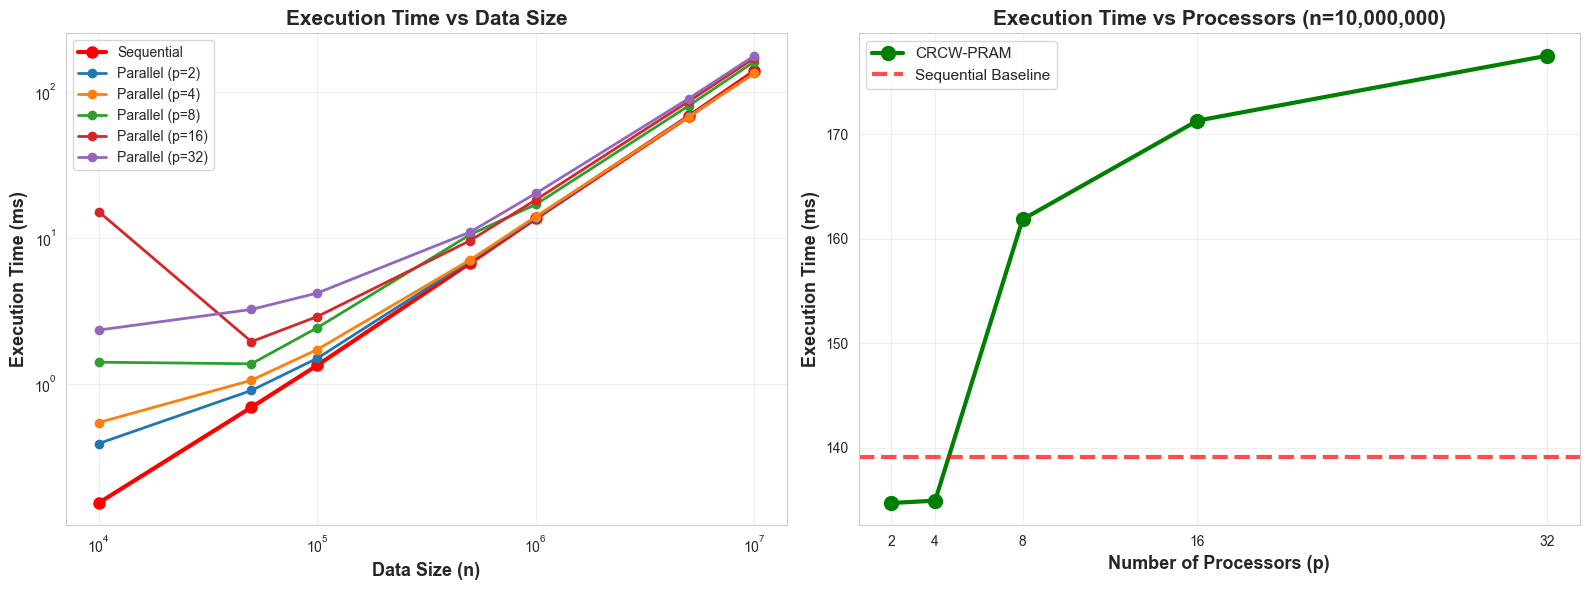

✓ Execution time comparison saved


/var/folders/x4/8tfv36kn2hs9b34nb1skkzsw0000gn/T/ipykernel_77768/1418486083.py:85: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x4/8tfv36kn2hs9b34nb1skkzsw0000gn/T/ipykernel_77768/1418486083.py:86: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('speedup_efficiency_analysis.png', dpi=300, bbox_inches='tight')
/Users/nurulgofran/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


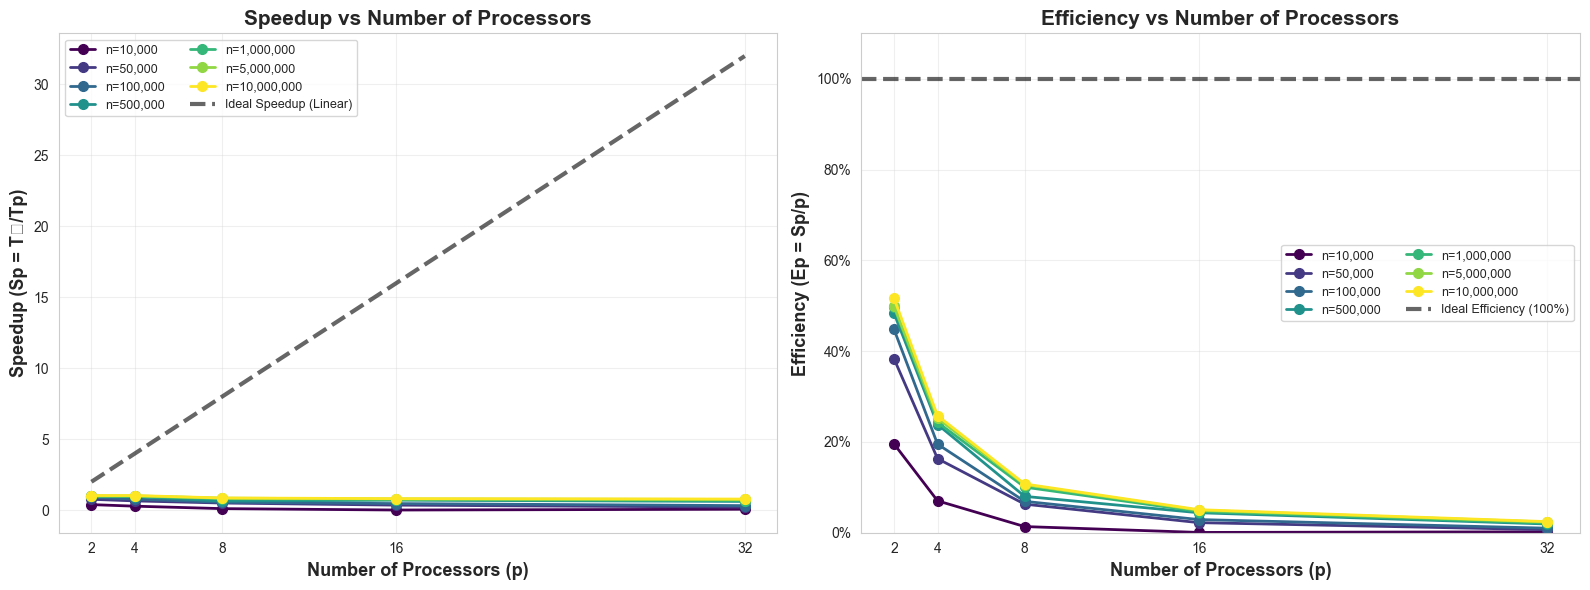

✓ Speedup and efficiency analysis saved


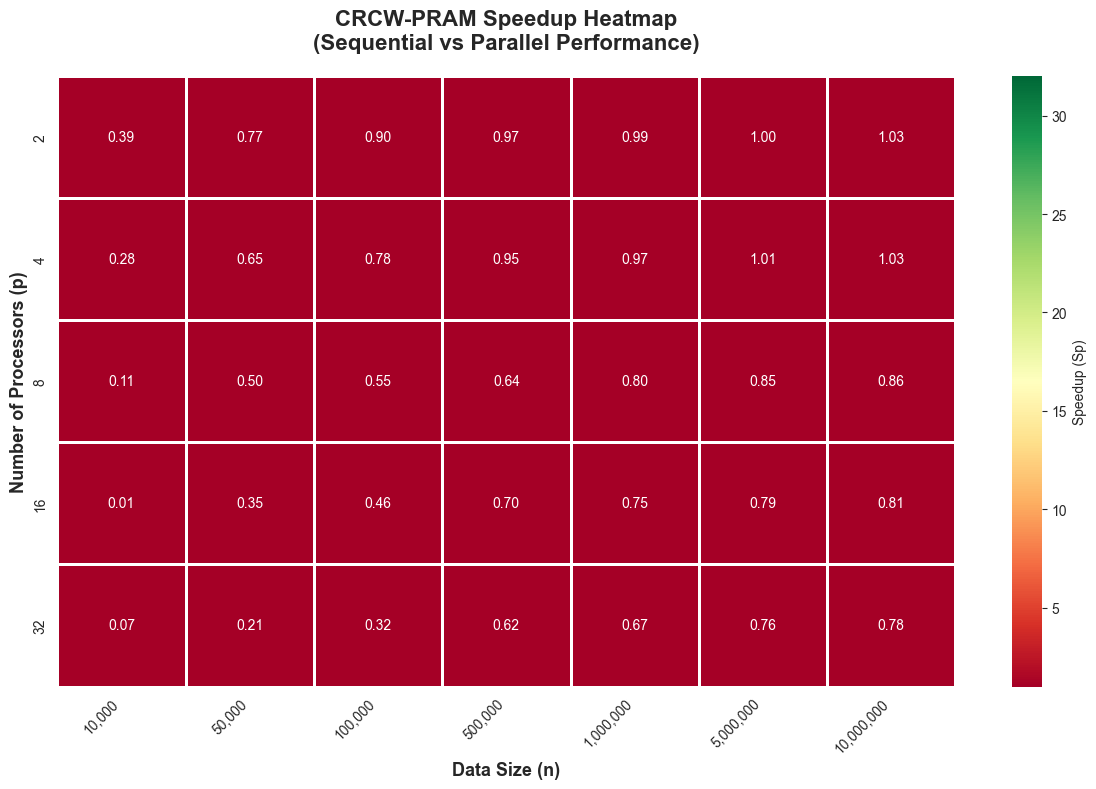

✓ Speedup heatmap saved
All visualizations generated successfully!


In [39]:
print("Generating all visualizations...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

seq_data = df_results[df_results['algorithm'] == 'Sequential']
axes[0].plot(seq_data['size'], seq_data['time_ms'], 'o-', linewidth=3, 
             label='Sequential', markersize=8, color='red')

for p in [2, 4, 8, 16, 32]:
    parallel_data = df_results[(df_results['algorithm'] == 'CRCW-PRAM') & 
                               (df_results['processors'] == p)]
    axes[0].plot(parallel_data['size'], parallel_data['time_ms'], 'o-', 
                 linewidth=2, label=f'Parallel (p={p})', markersize=6)

axes[0].set_xlabel('Data Size (n)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Execution Time (ms)', fontsize=13, fontweight='bold')
axes[0].set_title('Execution Time vs Data Size', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')

largest_data = df_results[df_results['size'] == largest_size]
parallel_largest = largest_data[largest_data['processors'] > 1]
seq_largest = largest_data[largest_data['algorithm'] == 'Sequential']['time_ms'].values[0]

axes[1].plot(parallel_largest['processors'], parallel_largest['time_ms'], 
             'o-', linewidth=3, markersize=10, label='CRCW-PRAM', color='green')
axes[1].axhline(y=seq_largest, color='red', linestyle='--', linewidth=3, 
                label='Sequential Baseline', alpha=0.7)

axes[1].set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Execution Time (ms)', fontsize=13, fontweight='bold')
axes[1].set_title(f'Execution Time vs Processors (n={largest_size:,})', 
                  fontsize=15, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(processor_counts)

plt.tight_layout()
plt.savefig('execution_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Execution time comparison saved")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(test_sizes)))
for idx, size in enumerate(test_sizes):
    size_data = df_results[(df_results['size'] == size) & 
                           (df_results['processors'] > 1)]
    axes[0].plot(size_data['processors'], size_data['speedup'], 
                 'o-', linewidth=2, markersize=7, 
                 label=f'n={size:,}', color=colors[idx])

axes[0].plot(processor_counts, processor_counts, 'k--', linewidth=3, 
             label='Ideal Speedup (Linear)', alpha=0.6)

axes[0].set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Speedup (Sp = T₁/Tp)', fontsize=13, fontweight='bold')
axes[0].set_title('Speedup vs Number of Processors', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=9, ncol=2)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(processor_counts)

for idx, size in enumerate(test_sizes):
    size_data = df_results[(df_results['size'] == size) & 
                           (df_results['processors'] > 1)]
    axes[1].plot(size_data['processors'], size_data['efficiency'], 
                 'o-', linewidth=2, markersize=7, 
                 label=f'n={size:,}', color=colors[idx])

axes[1].axhline(y=1.0, color='black', linestyle='--', linewidth=3, 
                label='Ideal Efficiency (100%)', alpha=0.6)

axes[1].set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Efficiency (Ep = Sp/p)', fontsize=13, fontweight='bold')
axes[1].set_title('Efficiency vs Number of Processors', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=9, ncol=2)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(processor_counts)
axes[1].set_ylim([0, 1.1])
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.savefig('speedup_efficiency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Speedup and efficiency analysis saved")

fig, ax = plt.subplots(figsize=(12, 8))

parallel_data = df_results[(df_results['algorithm'] == 'CRCW-PRAM') & 
                           (df_results['processors'] > 1)]
pivot_speedup = parallel_data.pivot(index='processors', columns='size', values='speedup')

sns.heatmap(pivot_speedup, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Speedup (Sp)'}, ax=ax,
            linewidths=1, linecolor='white', vmin=1, vmax=max(processor_counts))

ax.set_title('CRCW-PRAM Speedup Heatmap\n(Sequential vs Parallel Performance)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Data Size (n)', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Processors (p)', fontsize=13, fontweight='bold')

ax.set_xticklabels([f'{int(float(label.get_text())):,}' for label in ax.get_xticklabels()], 
                    rotation=45, ha='right')

plt.tight_layout()
plt.savefig('speedup_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Speedup heatmap saved")


print("All visualizations generated successfully!")
